# Calculate The Mean Shape of Each Digit

## Prepare The Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

In [2]:
train = pd.read_csv("train.csv").as_matrix()
test = pd.read_csv("test.csv").as_matrix()
X = train[0:, 1:]
Y = train[0:, 0]

In [3]:
TEST_SIZE = 0.1
TRAIN_SIZE = 0.9
X_train, X_val, Y_train, Y_val = train_test_split(X, Y,
                                                 test_size=TEST_SIZE,
                                                 random_state=42)

## Defination of Functions

In [4]:
def collectImageOfALabel(X_train, Y_train):
    numOfTestCase = len(X_train)
    imageOfDigit = dict()
    for i in range(numOfTestCase):
        label = Y_train[i]
        if label in imageOfDigit.keys():
            imageOfDigit[label].append(X_train[i])
        else:
            imageOfDigit[label] = [X_train[i]]
    return imageOfDigit

In [5]:
def meanOfALabel(imageOfDigit):
    mean = dict()
    for label in imageOfDigit.keys():
        length = len(imageOfDigit[label])
        imageOfDigit[label] = np.array(imageOfDigit[label])
        mean[label] = np.mean(imageOfDigit[label], axis=0)
    return mean

In [6]:
def plot_image(indexOfDigits, size=28, title="index"):
    plt.figure(figsize=(8, 8))
    plt.gray()
    for label in indexOfDigits.keys():
        plt.subplot(4, 3, label + 1)
        plt.imshow(indexOfDigits[label].reshape(size, size))
        plt.title("{} of {}".format(title, label))
    plt.show()

In [7]:
def predict(X_val, mean):
    guesses = [-1] * len(X_val)
    for i in range(len(X_val)):
        distance = []
        for j in range(10):
            d = ((mean[j] - np.array(X_val[i]))**2).sum()
            distance.append(d)
        closest = min(distance)
        for j in range(10):
            if distance[j] == closest:
                guesses[i] = j
                break
    return guesses

In [8]:
def evaluate(X_val, Y_val):
    numOfValCase = len(X_val)
    right_count = 0
    wrongs = dict()
    for i in range(numOfValCase):
        if guesses[i] == Y_val[i]:
            right_count += 1
        else:
            if Y_val[i] in wrongs.keys():
                wrongs[Y_val[i]].append(guesses[i])
            else:
                wrongs[Y_val[i]] = [guesses[i]]
    accuracy = right_count / numOfValCase
    print("{} / {} = {}".format(right_count, numOfValCase, accuracy))
    return wrongs

In [9]:
def plotWrongMat(wrongs):
    wrongMat = [[0 for _ in range(10)] for _ in range(10)]
    for i in range(10):
        s = Counter(wrongs[i])
        for j in range(10):
            wrongMat[i][j] = s[j]
    plt.figure(figsize=(10, 10))
    plt.imshow(wrongMat)
    plt.show()
    print(wrongMat)
    print(right_count)

In [10]:
# res = pd.DataFrame(columns=['ImageId','Label'])
# res['ImageId'] = np.arange(1, 28001)
# res['Label'] = guesses
# res.to_csv('test_predictions.csv', index=False)

In [11]:
def cmpStd(imageOfDigit):
    std = dict()
    for i in range(10):
        std[i] = np.std(imageOfDigit[i], axis=0)
    return std

In [12]:
def cmpMedian(imageOfDigit):
    median = dict()
    for i in range(10):
        median[i] = np.median(imageOfDigit[i], axis=1)
    return median

# PCA Analysis

## The ratio of number of components to explained variance

In [13]:
n_components_array = [1,2,3,4,5,10,20,50,100,200,300,400,500]

In [14]:
def cmpPCA(X_train, n=None):
    pca = PCA(n_components=n)
    pca.fit(X_train.T)
    return pca

In [15]:
def plotPCAVarianceRatio(pca, n_components_array):
    vr = []
    for n in n_components_array:
        vr.append(sum(pca.explained_variance_ratio_[:n]))
    plt.figure(figsize=(8, 4))
    plt.xlabel("number of PCA components", size = 20)
    plt.ylabel("variance ratio", size=20)
    plt.xscale("log")
    plt.ylim(9e-2, 1.1)
    plt.xlim(1)
    plt.xticks(n_components_array)
    plt.grid(which="both")
    plt.plot(n_components_array, vr, 'k.-')
    plt.show()

In [16]:
pca = cmpPCA(X_train)

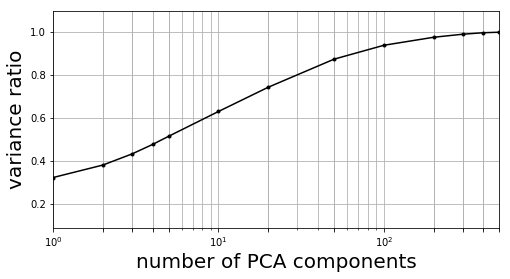

In [17]:
plotPCAVarianceRatio(pca, n_components_array)

When number of components is ~200, it can explain >90% of the data. I will use 200 and 300 components to predict.

In [25]:
def plotPCASingularValues(pca):
    Y = pca.singular_values_
    plt.figure(figsize=(8, 4))
    plt.xlabel("PCA components", size = 20)
    plt.ylabel("Singular Values", size=20)
    #plt.xscale("log")
    #plt.ylim(9e-2, 1.1)
    #plt.xlim(1)
    #plt.xticks(n_components_array)
    plt.grid(which="both")
    plt.plot(list(range(1,785)), Y, 'k.-')
    plt.show()

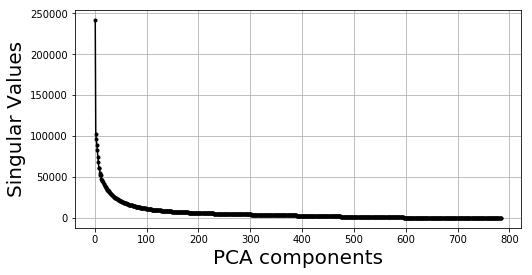

In [26]:
plotPCASingularValues(pca)

# Compare The Result with 200 components and all components

In [50]:
pca = PCA(200)
X_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

### With PCA

In [51]:
imageOfDigit = collectImageOfALabel(X_pca, Y_train)
mean = meanOfALabel(imageOfDigit)
guesses = predict(X_val_pca, mean)
wrongs = evaluate(X_val_pca, Y_val)

3411 / 4200 = 0.8121428571428572


### Without PCA

In [52]:
imageOfDigit = collectImageOfALabel(X_train, Y_train)
mean = meanOfALabel(imageOfDigit)
guesses = predict(X_val, mean)
wrongs = evaluate(X_val, Y_val)

3412 / 4200 = 0.8123809523809524


It is almost the same. **Can we say the PAC did a great job, while just limited the the mean method? Or there are something wrong with PCA?**

# Decision Tree with or without PCA

In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score
import time
import graphviz

### Without PCA, Use All Features

In [54]:
startTime = time.time()
clf = DecisionTreeClassifier(random_state=40)
clf.fit(X_train, Y_train)
print(clf.score(X_val, Y_val))
endTime = time.time()
print("{} seconds".format(endTime - startTime))

0.850714285714
12.215938806533813 seconds


In [55]:
dot_data = export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("without PCA")

'without PCA.pdf'

### Without PCA, Use 200 Features

In [56]:
startTime = time.time()
clf = DecisionTreeClassifier(max_features=200, random_state=40)
clf.fit(X_train, Y_train)
print(clf.score(X_val, Y_val))
endTime = time.time()
print("{} seconds".format(endTime - startTime))
tree = clf.tree_

0.854285714286
3.003453016281128 seconds


In [57]:
#dot_data = export_graphviz(clf, out_file=None) 
#graph = graphviz.Source(dot_data) 
#graph.render("without PCA")

### With PCA

In [58]:
startTime = time.time()
pca = PCA(n_components=100)
pca.fit(X_train)
X_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
clf_pca = DecisionTreeClassifier(random_state=40)
clf_pca.fit(X_pca, Y_train)
print(clf_pca.score(X_val_pca, Y_val))
endTime = time.time()
print("{} seconds".format(endTime - startTime))
tree_pca = clf_pca.tree_

0.824047619048
15.932177305221558 seconds


### Explore Tree Structure

In [60]:
print(tree.max_depth)
print(tree.node_count)

35
6357


In [61]:
print(tree_pca.max_depth)
print(tree_pca.node_count)

46
6623


# Results of Decision Tree with PCA

In [64]:
# prepare the test data
X_test = pca.transform(test)
result = clf_pca.predict(X_test)

# save to file
np.savetxt('pca.csv',
          np.c_[range(1, len(X_test) + 1), result],
          delimiter=',',
          header='ImageId,Label',
          comments='',
          fmt='%d')

# Random Forest with PCA

In [25]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
pca = PCA(200)
pca.fit(X_train)
X_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test = pca.transform(test)

In [35]:
clf_rf = RandomForestClassifier(max_depth = 35, random_state=40)

In [32]:
clf_rf.fit(X_pca, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=40, verbose=0, warm_start=False)

In [33]:
clf_rf.score(X_val_pca, Y_val)

0.86452380952380947

In [22]:
prediction = clf_rf.predict(X_test)

In [24]:
submissions = pd.DataFrame({"ImageId":list(range(1,len(prediction)+1)),
                           "Label":prediction})
submissions.to_csv("RF.csv", index=False, header=True)

# Random Forest without PCA

In [36]:
clf_rf = RandomForestClassifier(max_depth = 35, random_state=40)

In [37]:
clf_rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=35, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=40, verbose=0, warm_start=False)

In [38]:
clf_rf.score(X_val, Y_val)

0.94119047619047624

In [39]:
prediction = clf_rf.predict(test)

In [40]:
submissions = pd.DataFrame({"ImageId":list(range(1,len(prediction)+1)),
                           "Label":prediction})
submissions.to_csv("RF.csv", index=False, header=True)

# Correlation Graph

In [47]:
correlation = pd.DataFrame(X).corr()

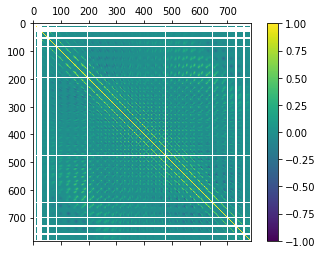

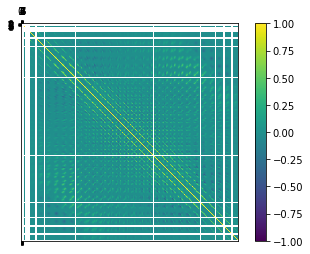

In [49]:
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlation, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
#ax.set_xticklabels(names)
#ax.set_yticklabels(names)
plt.show()